# **NLP Cleaning and EDA**

### **By:** Jiro Amato

### **Date:** May, 30, 2024
### **Edited:** July 7, 2024

---

## ***Introduction:***

In this notebook, we wll be going through a first pass of the training dataset for the sentiment analysis model. This dataset contains 4,840 financial articles that have been classified as positive, neutral or negative by 16 financial professionals. It is crucial to complete this step as it sets the foundation for the rest of the model. We will be looking through text-preprocessing and some EDA using techniques such as Bag of Words and TF-IDF to vecotrize the text data.

**Other datasets of the project (will investigate further):**

The second dataset of the project contains daily news gather from 2009-2020 which has the following:

### ***Data Dictionary (2nd Dataset)***

**Column Name:**   
Contains **843,062** unique articles.

- `headline:` The headline of the news article
- `url:` Link to the article
- `publisher:` Name of the publisher
- `date:` Date the article was released
- `stock:` The stock that the article refers to

Lastly, the third dataset contains the daily historical price of the S&P 500 index from 2000-2024 which has the following:

### ***Data Dictionary (3rd Dataset)***

**Column Name:**
Contains **6,038** observations.  

- `Date:` Date of when the price was recorded
- `Open:` Price level during the market opening
- `High:` Highest that price went to during trading hours
- `Low:` Lowest that price went to during trading hours
- `Adj Close:` The closing price (adjusted to include any corporate decision made before the next trading day)
- `Volume:` The total amount that the index was traded expressed in $

---

## ***Table of contents***<a id='toc0_'></a>    
- 1.1. [***Preface: Verifying the cleanliness of our data***](#toc1_1_)    
    - 1.1.1. [***Loading Datasets***](#toc1_1_1_)    
    - 1.1.2. [***Data Dictionary***](#toc1_1_2_)    
    - 1.1.3. [***Checking for nulls***](#toc1_1_3_)    
    - 1.1.4. [***Checking for duplicates***](#toc1_1_4_)    
- 1.2. [***Exploratory Data Analysis***](#toc1_2_)    
    - 1.2.1. [***Sentiment Breakdown/Imbalance***](#toc1_2_1_)    
    - 1.2.2. [***Counts of words and characters***](#toc1_2_2_)    
- 1.3. [***Vectorization***](#toc1_3_)    
    - 1.3.1. [***Data Standardization***](#toc1_3_1_)    
    - 1.3.2. [***Tokenization and Lemmatization***](#toc1_3_2_)    
    - 1.3.3. [***Stop-word and empty string removal***](#toc1_3_3_)    
    - 1.3.4. [***Tokenizer function***](#toc1_3_4_)    
    - 1.3.5. [***Bag of Words***](#toc1_3_5_)    
    - 1.3.6. [***TF-IDF***](#toc1_3_6_)    
    - 1.3.7. [***Word Embeddings (Word2Vec)***](#toc1_3_7_)    
      - 1.3.7.1. [***Word Similarity***](#toc1_3_7_1_)    
      - 1.3.7.2. [***Embedding the Dataset***](#toc1_3_7_2_)    
- 1.4. [***Next Steps***](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Importing necessary libraries

# Libraries for data manipulation
import numpy as np
import pandas as pd
import os # For path name manipulation

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Train/Test splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# NLP specific libraries
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.1. <a id='toc1_1_'></a>[***Preface: Verifying the cleanliness of our data***](#toc0_)

### 1.1.1. <a id='toc1_1_1_'></a>[***Loading Datasets***](#toc0_)

Sourced code to open multiple files in a for-loop [here](https://saturncloud.io/blog/how-to-import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe/).

In [2]:
# Loading the dataset for training the sentiment analysis model

# Instantiating an empty dataframe
phrase_bank_df = pd.DataFrame()

# Creating a list of the file names for a for-loop
files = ['Sentences_AllAgree.txt', 'Sentences_75Agree.txt', 'Sentences_66Agree.txt', 'Sentences_50Agree.txt']
path = 'C:/Users/amato/Desktop/Brainstation/Capstone/data/'

# For-loop to load in all the files and combine them into one
for file in files:
    df = pd.read_csv(os.path.join(path, file), encoding='ISO-8859-1', delimiter='@', names=['Headline', 'Sentiment'])  # The files are in "@" separated format
    phrase_bank_df = pd.concat([phrase_bank_df, df], axis=0, ignore_index=True)

phrase_bank_df


,Headline,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
14775,LONDON MarketWatch -- Share prices ended lower...,negative
14776,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
14777,Operating profit fell to EUR 35.4 mn from EUR ...,negative
14778,Net sales of the Paper segment decreased to EU...,negative


### 1.1.2. <a id='toc1_1_2_'></a>[***Data Dictionary***](#toc0_)

**Column Name:**   

- `Headline:` The headline of the news article
- `Sentiment:` Classifications by positive, neutral or negative. These classifications were agreed upon by 16 professionals in the Finance domain.

### 1.1.3. <a id='toc1_1_3_'></a>[***Checking for nulls***](#toc0_)

In [3]:
# Checking for nulls

phrase_bank_df.isna().sum()

Headline     0
Sentiment    0
dtype: int64

We do not have any null values.

### 1.1.4. <a id='toc1_1_4_'></a>[***Checking for duplicates***](#toc0_)

In [4]:
# Checking for duplicates

phrase_bank_df.duplicated(keep='first').sum()

9940

We have 9,940 duplicates in our dataframe. Let's check what they are .

In [5]:
phrase_bank_df[phrase_bank_df.duplicated(keep='first') == True].head()

,Headline,Sentiment
519,The issuer is solely responsible for the conte...,neutral
626,The report profiles 614 companies including ma...,neutral
929,Ahlstrom 's share is quoted on the NASDAQ OMX ...,neutral
1027,SSH Communications Security Corporation is hea...,neutral
1409,The company serves customers in various indust...,neutral


In [6]:
# Dropping duplicates

phrase_bank_df = phrase_bank_df.drop_duplicates(keep='first', ignore_index=True)

In [7]:
# Sanity check

phrase_bank_df.duplicated().sum()

0

In [8]:
# Checking the cleaned dataframe

phrase_bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4840 entries, 0 to 4839
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headline   4840 non-null   object
 1   Sentiment  4840 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [9]:
phrase_bank_df

,Headline,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
4835,Bosse added that Trygvesta does not have the f...,negative
4836,Finnish-Swedish Stora Enso does not understand...,negative
4837,The 2015 target for net sales has been set at ...,positive
4838,have notified that as a result of the Company ...,negative


The dataframe now has 4840 rows with no nulls and duplicates. We can now proceed to start with an EDA and data-preprocessing.

In [53]:
# Saving dataset for next steps

phrase_bank_df.to_csv('../data/df_clean.csv', index=False)

## 1.2. <a id='toc1_2_'></a>[***Exploratory Data Analysis***](#toc0_)

### 1.2.1. <a id='toc1_2_1_'></a>[***Sentiment Breakdown/Imbalance***](#toc0_)

The first thing that I will be exploring is the breakdown of sentiment in the dataset. After, I will be simplifying the problem statement by combining neutral with positive to just have a binary sentiment output

In [11]:
# Breakdown of positive, neutral and negative sentiments in percentages

positive = phrase_bank_df['Sentiment'].value_counts()['positive'] # We know from our last code that we have 4840 observations
negative = phrase_bank_df['Sentiment'].value_counts()['negative']
neutral = phrase_bank_df['Sentiment'].value_counts()['neutral']

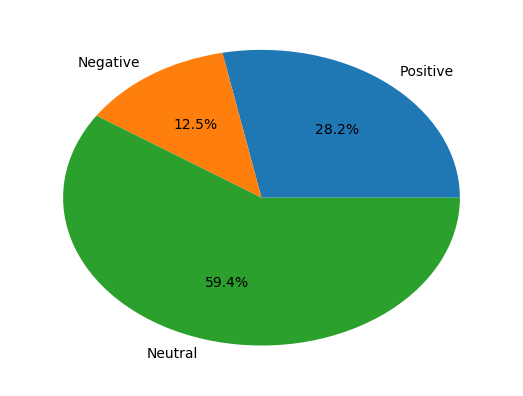

In [12]:
# Pie chart to show the breakdown of sentiment in the dataset
plt.figure()
plt.pie([positive, negative, neutral], labels=['Positive', 'Negative', 'Neutral'], autopct='%1.1f%%')
plt.show()

We can see that the neutral sentiment make up almost 60% of our data with positive at 28.2% and negative at 12.5%. The financial phrase bank is not balanced when it comes to outcomes. If we consolidate `Neutral` to `Positive` we will have data that is tremendously unbalanced towards positive sentiment. By looking at this, it seems more reasonable to consolidate `Neutral` into `Negative`instead. Although the data will still be unbalanced, it will not be as bad as if we consolidated `Neutral` and `Positive` together.

In [13]:
# Mapping sentiments into binary (consolidating neutral into negative)
phrase_bank_df['Sentiment'] = np.where(phrase_bank_df['Sentiment'] == 'positive', 1, 0)

# Sanity check
phrase_bank_df['Sentiment'].value_counts()


C:\Users\amato\AppData\Local\Temp\ipykernel_85284\629409407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_bank_df['Sentiment'] = np.where(phrase_bank_df['Sentiment'] == 'positive', 1, 0)


0    3477
1    1363
Name: Sentiment, dtype: int64

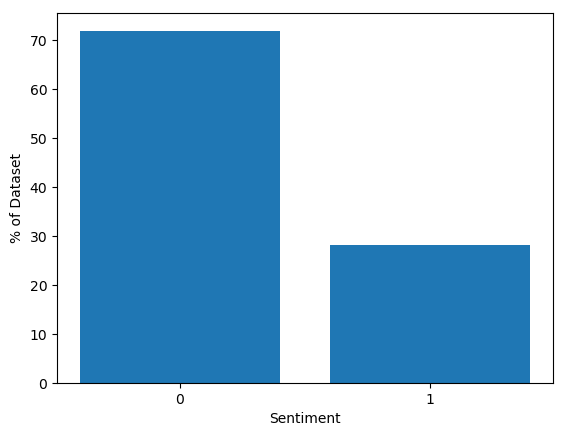

Class imbalance: [0.72 0.28]


In [14]:
# Class imbalance

values, counts = np.unique(phrase_bank_df['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Sentiment')
plt.ylabel('% of Dataset')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

Quite a big class imbalance here. Since this is a first pass EDA, we will see where this takes us for now. Some changes that I am already thinking about for future iterations are implementing models that allow for multi-class classification like KNN and DT. Logistic regression is also capable of this but it is costly in computation (we can accept this as our dataset is relatively low).

### 1.2.2. <a id='toc1_2_2_'></a>[***Counts of words and characters***](#toc0_)

Before we start vectorizing our data, it is good to explore the nature of our headlines when it comes to the count of characters and words. We will do the following below:

In [15]:
# Checking the length of characters in each headline
length = len(phrase_bank_df['Headline'][0])


In [16]:
print(phrase_bank_df['Headline'][0])
print(length)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
127


In [17]:
# Creating a new column that calculates the number of characters in each headline
phrase_bank_df['char_count'] = phrase_bank_df['Headline'].apply(lambda x: len(x))

# Sanity check
phrase_bank_df.head()

C:\Users\amato\AppData\Local\Temp\ipykernel_85284\192333379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_bank_df['char_count'] = phrase_bank_df['Headline'].apply(lambda x: len(x))


,Headline,Sentiment,char_count
0,"According to Gran , the company has no plans t...",0,127
1,"For the last quarter of 2010 , Componenta 's n...",1,193
2,"In the third quarter of 2010 , net sales incre...",1,125
3,Operating profit rose to EUR 13.1 mn from EUR ...,1,122
4,"Operating profit totalled EUR 21.1 mn , up fro...",1,103


In [18]:
# Counting the words in a headline using split() and len()
word_count = len(phrase_bank_df['Headline'][0].split())
print(word_count)

25


In [19]:
# Applying to the entire row
phrase_bank_df['word_count'] = phrase_bank_df['Headline'].str.split().apply(len)

# Sanity check
phrase_bank_df.head()

C:\Users\amato\AppData\Local\Temp\ipykernel_85284\1647580670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_bank_df['word_count'] = phrase_bank_df['Headline'].str.split().apply(len)


,Headline,Sentiment,char_count,word_count
0,"According to Gran , the company has no plans t...",0,127,25
1,"For the last quarter of 2010 , Componenta 's n...",1,193,39
2,"In the third quarter of 2010 , net sales incre...",1,125,29
3,Operating profit rose to EUR 13.1 mn from EUR ...,1,122,24
4,"Operating profit totalled EUR 21.1 mn , up fro...",1,103,22


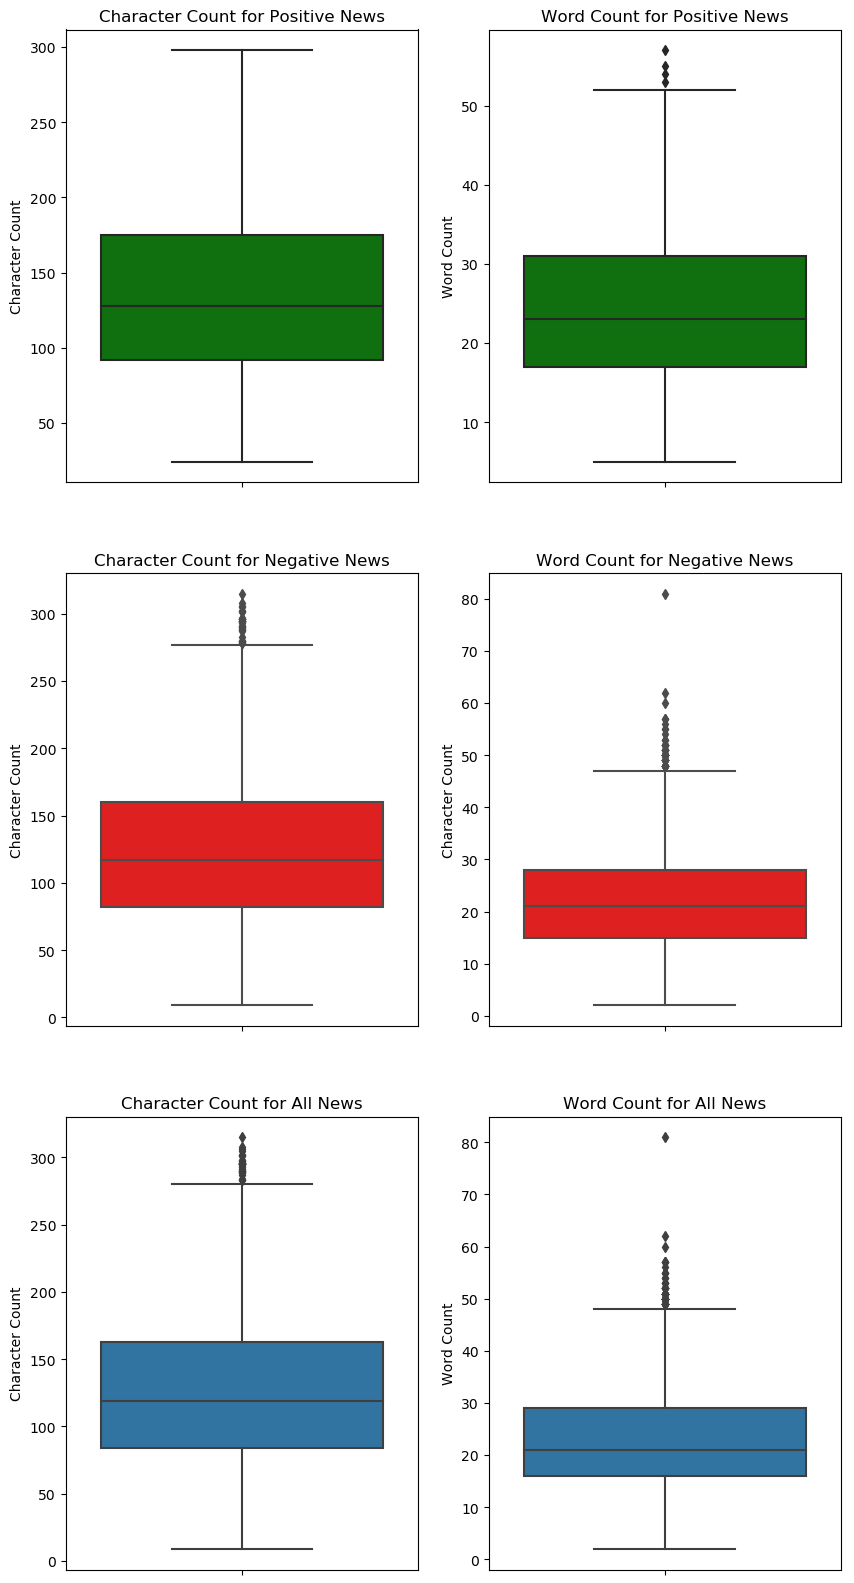

In [20]:
# Visualizing the character and word counts in box plots

plt.subplots(3, 2, figsize=(10, 20))

plt.subplot(3, 2, 1)
sns.boxplot(y=phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 1, 'char_count'], color='green')
plt.ylabel('Character Count')
plt.title('Character Count for Positive News')

plt.subplot(3, 2, 2)
sns.boxplot(y=phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 1, 'word_count'], color='green')
plt.ylabel('Word Count')
plt.title('Word Count for Positive News')

plt.subplot(3, 2, 3)
sns.boxplot(y=phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 0, 'char_count'], color='red')
plt.ylabel('Character Count')
plt.title('Character Count for Negative News')

plt.subplot(3, 2, 4)
sns.boxplot(y=phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 0, 'word_count'], color='red')
plt.ylabel('Character Count')
plt.title('Word Count for Negative News')

plt.subplot(3, 2, 5)
sns.boxplot(y=phrase_bank_df['char_count'])
plt.ylabel('Character Count')
plt.title('Character Count for All News')

plt.subplot(3, 2, 6)
sns.boxplot(y=phrase_bank_df['word_count'])
plt.ylabel('Word Count')
plt.title('Word Count for All News')

plt.show()

## 1.3. <a id='toc1_3_'></a>[***Vectorization***](#toc0_)

The next part of our data preprocessing is to vectorize our `Headline` column in order to make our data approriate inputs to any model.

### 1.3.1. <a id='toc1_3_1_'></a>[***Data Standardization***](#toc0_)

In this step I am going to transform the headlines all in lowercase and take out punctuations.

In [21]:
sentence = phrase_bank_df['Headline'][0]

for punctuation in string.punctuation:
    sentence = sentence.replace(punctuation,'')

sentence_new = sentence.lower()
sentence_new

'according to gran  the company has no plans to move all production to russia  although that is where the company is growing '

### 1.3.2. <a id='toc1_3_2_'></a>[***Tokenization and Lemmatization***](#toc0_)

After taking out the punctuations, I am going to split the headline into a list of words which I then lemmatize.

Lemmatization is the process of reducing a word to its root form called 'lemma'. This is the dictionary form of a root (ex: laziness to lazy). This allows us to have more accurate and meaningful root words in comparison to stemming where it can lead to unusual rootwords as it is 'rules-based' rather than vocabulary-based (ex: laziness to lazi). For this reason, I will attempt to lemmatize the dataset. The only draw back of lemmatization is the computational cost but since we are dealing with a rather small dataset, we can afford to lose some efficiency for accuracy.

In [22]:
# Splitting the headline into a list of words
listofwords = sentence_new.split(' ')
listofwords

['according',
 'to',
 'gran',
 '',
 'the',
 'company',
 'has',
 'no',
 'plans',
 'to',
 'move',
 'all',
 'production',
 'to',
 'russia',
 '',
 'although',
 'that',
 'is',
 'where',
 'the',
 'company',
 'is',
 'growing',
 '']

In [23]:
# Lemmatization

wnl = WordNetLemmatizer()

lemmatized_sentence = [wnl.lemmatize(i) for i in listofwords]
lemmatized_sentence

['according',
 'to',
 'gran',
 '',
 'the',
 'company',
 'ha',
 'no',
 'plan',
 'to',
 'move',
 'all',
 'production',
 'to',
 'russia',
 '',
 'although',
 'that',
 'is',
 'where',
 'the',
 'company',
 'is',
 'growing',
 '']

### 1.3.3. <a id='toc1_3_3_'></a>[***Stop-word and empty string removal***](#toc0_)

The next step is to remove any stop-words (words without significant meaning such as 'the' and 'like') and any leftover whitespaces.

In [24]:
# Removing stop-words and empty strings

stop_words = stopwords.words('english')

words_clean = [word for word in lemmatized_sentence if word not in stop_words and (word != '')]
words_clean

['according',
 'gran',
 'company',
 'ha',
 'plan',
 'move',
 'production',
 'russia',
 'although',
 'company',
 'growing']

As expected, we now have processed the headline appropriately. However noticed that there are words like 'ha' in our tokenized headline that is meaningless. I will words that have one or two elements that have little to no meaning.

In [25]:
# Removing any other words with 1 or 2 letters that are insignificant
words_final = [word for word in words_clean if (len(word) != 1) and (len(word) != 2)]
words_final

['according',
 'gran',
 'company',
 'plan',
 'move',
 'production',
 'russia',
 'although',
 'company',
 'growing']

### 1.3.4. <a id='toc1_3_4_'></a>[***Tokenizer function***](#toc0_)

Now that all the steps for text processing have been outline. We are now going to put everything in a function in order to create our own tokenizer:

In [26]:
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def my_tokenizer(sentence: str) -> list[str]:
    """
    Tokenizes a sentence into a list of lemmatized words, removing punctuation, stop words, and insignificant short words.

    Input:
        sentence (str): The input sentence to be tokenized.

    Output:
        list: A list of lemmatized tokens from the input sentence.
    """
    # transform string into lower case and take out punctuations
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '').lower()

    # tokenization
    listofwords = sentence.split(' ')
    lemmatized_words = []

    # removal of stop-words
    for word in listofwords:
        if word not in stop_words and (word != ''):
            # lemmatizing
            lemma = wnl.lemmatize(word)
            lemmatized_words.append(lemma)
            
    # Removing any other words with 1 or 2 letters that are insignificant        
    tokenized_list = [word for word in lemmatized_words if (len(word) != 1) and (len(word) != 2)]

    return tokenized_list


### 1.3.5. <a id='toc1_3_5_'></a>[***Bag of Words***](#toc0_)

Now that I have created my own tokenizer, I am going to tokenize the dataset. Here we will be using Bag of words with a min_df=5.


In [27]:
# Split the data into Features and Target

X = phrase_bank_df['Headline']
y = phrase_bank_df['Sentiment']

# Sanity Check
print(X, '\n')
print(y)

0       According to Gran , the company has no plans t...
1       For the last quarter of 2010 , Componenta 's n...
2       In the third quarter of 2010 , net sales incre...
3       Operating profit rose to EUR 13.1 mn from EUR ...
4       Operating profit totalled EUR 21.1 mn , up fro...
                              ...                        
4835    Bosse added that Trygvesta does not have the f...
4836    Finnish-Swedish Stora Enso does not understand...
4837    The 2015 target for net sales has been set at ...
4838    have notified that as a result of the Company ...
4839    Net sales of the Paper segment decreased to EU...
Name: Headline, Length: 4840, dtype: object 

0       0
1       1
2       1
3       1
4       1
       ..
4835    0
4836    0
4837    1
4838    0
4839    0
Name: Sentiment, Length: 4840, dtype: int32


In [28]:
# Split the data into Train/Test Split. I will use a test split of 20%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [29]:
# Vectorize

bagofwords = CountVectorizer(min_df=5, 
                             tokenizer=my_tokenizer)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

X_train_transformed.shape

c:\Users\amato\anaconda3\envs\capstone\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3872, 1628)

Using the `CountVectorizer()` we can see that it has created 1,628 tokens. These tokens can be thought of as features of our data in which we will use to determine sentiment.

In [30]:
print(X_train_transformed)

  (0, 270)	1
  (0, 424)	1
  (0, 644)	1
  (0, 1064)	2
  (0, 1122)	1
  (0, 1242)	1
  (0, 1273)	1
  (0, 1620)	1
  (1, 609)	1
  (1, 695)	1
  (1, 1316)	1
  (2, 26)	1
  (2, 77)	1
  (2, 108)	1
  (2, 127)	1
  (2, 325)	3
  (2, 502)	1
  (2, 613)	1
  (2, 623)	1
  (2, 641)	1
  (2, 912)	1
  (2, 938)	3
  (2, 948)	1
  (2, 1021)	1
  (2, 1168)	1
  :	:
  (3867, 1108)	1
  (3867, 1144)	1
  (3868, 839)	1
  (3869, 29)	1
  (3869, 512)	1
  (3869, 647)	1
  (3869, 1071)	1
  (3869, 1295)	1
  (3870, 28)	1
  (3870, 29)	1
  (3870, 365)	1
  (3870, 483)	2
  (3870, 783)	1
  (3870, 1273)	1
  (3871, 76)	1
  (3871, 123)	1
  (3871, 270)	1
  (3871, 272)	1
  (3871, 483)	2
  (3871, 923)	2
  (3871, 965)	1
  (3871, 1023)	1
  (3871, 1072)	1
  (3871, 1616)	1
  (3871, 1620)	1


By default, vectorizing our dataframe turns it into a ***Sparse Matrix*** which only stores non-zero elements and their positions. This is more memory efficient as it most of the dataframe are zeros. 

From our sparse matrix we can visualize the most frequently occuring words in our corpus.

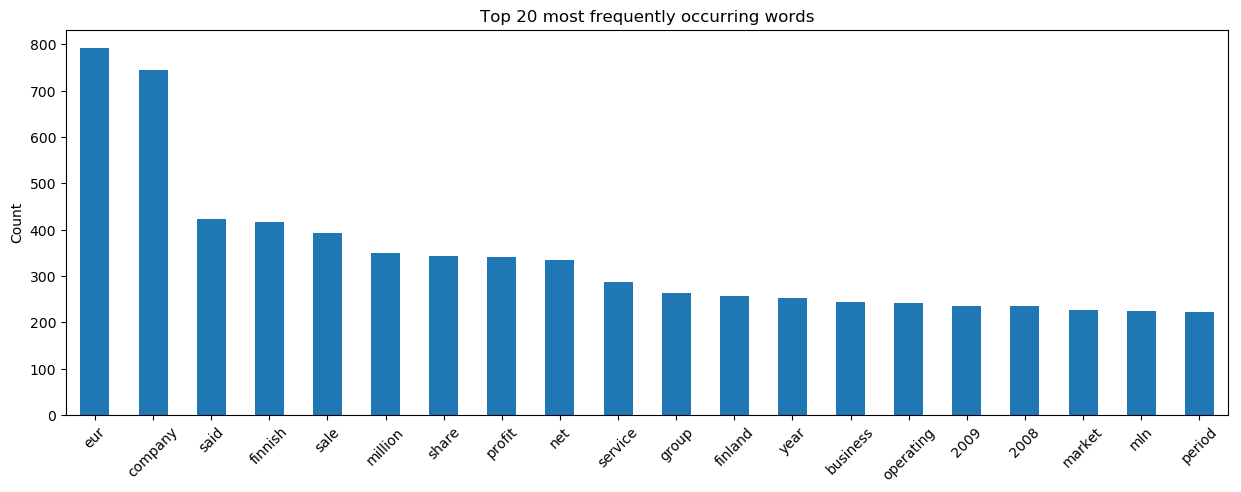

In [31]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

It looks like `eur` and `company` are the most frequent words in our corpus.

### 1.3.6. <a id='toc1_3_6_'></a>[***TF-IDF***](#toc0_)

`TF-IDF` is different way of vectorizing than in `Bag-of-Words` as it gives emphasis on the frequency of the word within each document and also how rare the word is in the entire corpus.

To understand how the `TF-IDF` score is calculated we need to breakdown its components:

1. **Term Frequency (TF)** - which is the number of times a given token appears in a document (headline in our case). This is the same as the content of our `bag-of-words` document-term matrix.
2. **Inverse Document Frequency (IDF)** - Inverse of the number of documents (headlines) a given word appears in. This is the `rarity` component.


Assuming we have a collection of tokens $[t_1, t_2, t_3, ..., t_n]$, and a collection of documents $D = [d_1, d_2, d_3, ... d_m]$ the overall formula for a `TF-IDF` score is:

$$TF(t_i, d_j) \times IDF(t_i, D)$$

Where:
* $TF(t_i, d_j)$ is the term frequency of term $i$ in document $j$.
* $IDF(t_i, D)$ is the inverse document frequency of term $i$ in all documents (rarity of the token across the entire corpus). In the simplest case it is:


$$\frac{{\text{The total number of documents in the corpus}}}{{\text{Number of documents containing token $t_i$ in the corpus}}+1} = \frac{len(D)}{len(\{\text{all $d_k$ such that $t_i \in d_k$} \})+1}$$

In [32]:
# using our custom tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5,
                        tokenizer=my_tokenizer)
tfidf.fit(X_train)

X_train_transformed = tfidf.transform(X_train)
X_test_transformed = tfidf.transform(X_test)

c:\Users\amato\anaconda3\envs\capstone\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


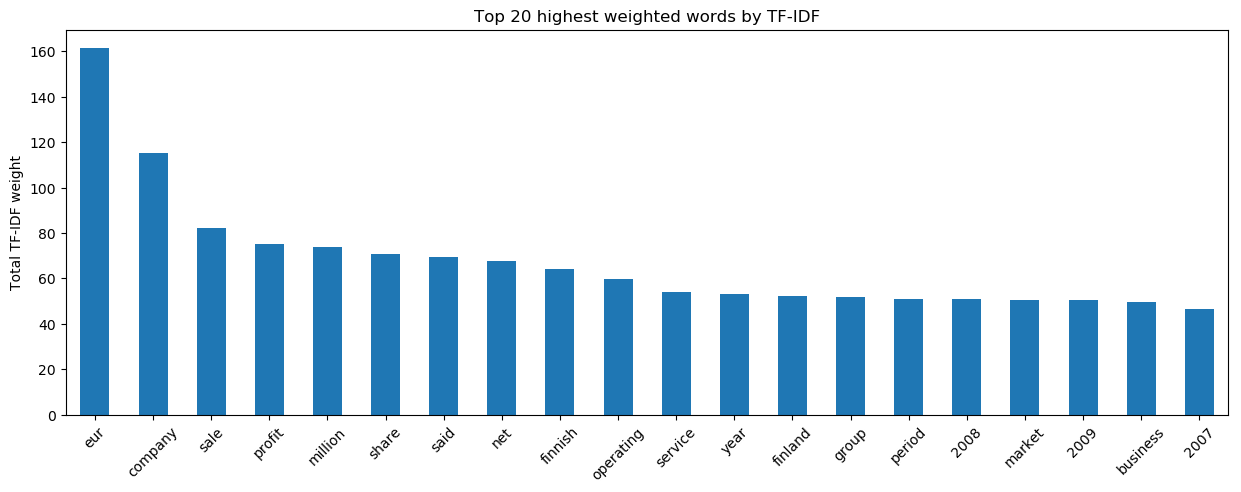

In [33]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

It looks like we are getting the similar results as `Bag-of-Words`. There are some words like million which are emphasized more using `TF-IDF` and words that weigh less like 'finnish' which are emphasized more in `Bag-of-Words`. This graph however looks at the weights associated with each lemma instead of frequency so the differences are to be expected

### 1.3.7. <a id='toc1_3_7_'></a>[***Word Embeddings (Word2Vec)***](#toc0_)

Now we will be looking at Word Embeddings using Word2Vec. 

Word embeddings represent words as dense vectors in a continuous vector space where semantically similar words are close to each other. These vectors capture semantic relationships between words.

We will be using `Word2Vec` from the `gensim` library to achieve this. In essence, Word2Vec is an algorithm based on neural networks which learns relationships between words measured by its `Cosine Distance` this is known as `Word Similarity`.

 Here is a visual of what the vector space looks like:<br>

<img src="assets/vector_space.png" alt="image">

We can see that the word `good` is closer to `okay` in the vector space compared to its distance to `turtle` indicating that `good` and `okay` have a close relationship to each other.

We won't train word embedding models in this notebook but we will load pretrained models. We will be using a model pretrained using Googles News Dataset which contains about 100 billion words. You can read more about this model [here](#https://code.google.com/archive/p/word2vec/).

You can also check out the different models available in gensim using the following code:

In [34]:
# Showing all available models in gensim
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


We will be using `'word2vec-google-news-300'`. The model is around 2GB so it may take a few minutes depending on your connection.

In [35]:
# Loading the model
model = gensim.downloader.load('word2vec-google-news-300')

In [36]:
# Checking the shape of the entire model
model.vectors.shape

(3000000, 300)

From the shape of the model, we can see that the model stores 3,000,000 words or tokens in its vocabulary. 300 is the dimensionality of each word vector (you can think of them as coordinates of a word vector). This captures the semantic meaning of words and allows us to determine 'similarity'.

Below is an example of a word vector:

In [37]:
# Extracting the word vector "money"
money_vector = model['money']
money_vector.shape

(300,)

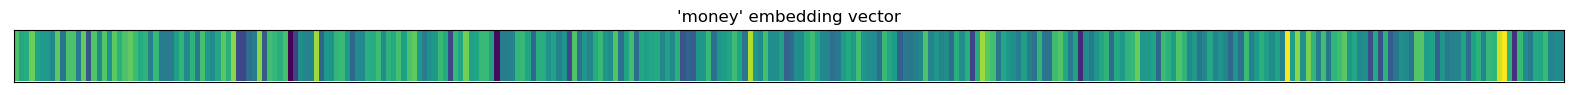

In [38]:
# Visualizing the word vector into heat map where greater values appear brighter
plt.figure(figsize=(20, 5))
# tiling the vector vertically to create a thicker heatmap
plt.imshow(np.tile(money_vector, (10, 1)))
plt.xticks([])
plt.yticks([])
plt.title(f'\'money\' embedding vector')
plt.show()

#### 1.3.7.1. <a id='toc1_3_7_1_'></a>[***Word Similarity***](#toc0_)

Word embeddings allow us to measure the 'similarity' between words which are quantified using `Cosine Distance` (also `Cosine Similarity`).

Using the `distance` method of our model, we can calculate the `Cosine Distance` between words. Recall that `Cosine Distance` is the cosine of the angle between two vectors (in our case word vectors) which is a value between 0 and 1. Higher distances mean greater dissimilar words.

In [39]:
# Calculating distance between "okay" and "good"
model.distance('okay', 'good')

0.47378790378570557

In [40]:
# Calculating distance between "okay" and "turtle"
model.distance("okay", "turtle")

0.8934817984700203

We can see that the words `okay` and `good` are more similar than the words `okay` and `turtle`.

#### 1.3.7.2. <a id='toc1_3_7_2_'></a>[***Embedding the Dataset***](#toc0_)

We can now embed the entire dataframe of labeled financial headlines using the Word2Vec model that we have implemented. Below is a function that embeds the headlines by doing the following:

1. Tokenizing the headline using the `my_tokenizer()` function that we created.
2. Using the Word2Vec model to find the individual word embeddings. (If the token is not in the model, then we would skip it).
3. Averaging the Word2Vec embeddings of the words in the headline.

In [41]:
def headline2vec(text: str) -> np.ndarray:
    """
    Converts a headline into a 300-dimensional embedding vector by averaging the Word2Vec embeddings of the words.

    Input:
        text (str): The input headline to be converted into an embedding vector.

    Output:
        numpy.ndarray: A 300-dimensional vector representing the headline.
    """
    tokenized = my_tokenizer(text)

    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)

        word_embeddings.append(vector)

    # average the word vectors
    headline_embedding = np.stack(word_embeddings).mean(axis=0)

    return headline_embedding

Recall the `phrase_bank_df` dataframe:

In [54]:
# Loading the phrase bank dataframe that we created before
phrase_bank_df = pd.read_csv('../data/df_clean.csv')
phrase_bank_df.head()

,Headline,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


We will compare headline embeddings of a positive sentiment headline and a negative sentiment headline to see if there are great distances between them.

From the dataframe above, we will take a random positive and a negative headline.

In [107]:
# Locating a random positive headline. Random state is for reproducibility
phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 'positive'].sample(1, random_state=2)

,Headline,Sentiment
296,Kalnapilio-Tauro Grupe ( Kalnapilis-Tauras Gro...,positive


We will embed the random positive headline at index 3765.

In [110]:
# Embedding the positive headline
pos_emb1 = headline2vec(phrase_bank_df['Headline'][296])

Now we will look for a negative headline.

In [111]:
# Locating a random negative headline
phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 'negative'].sample(1, random_state=2)

,Headline,Sentiment
2248,Repeats sees 2008 operating profit down y-y ( ...,negative


We have a negative headline at index 2230.

In [112]:
# Embedding the negative headline
neg_emb = headline2vec(phrase_bank_df['Headline'][2248])

Now we will calculate the `Cosine Similarity` using `cosine_distance` from `scipy`.

In [113]:
from scipy.spatial.distance import cosine as cosine_distance

cosine_distance(pos_emb1, neg_emb)

0.6655263274392924

There is a cosine distance of `0.67` which indicates a degree of ***dissimilarity*** between the headlines.

What if we embed another positive headline? We would assume that the cosine distance is shorter than what we have above.

Let's see if that's the case.

In [115]:
# Locating another positive headline
phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 'positive'].sample(1, random_state=17)

,Headline,Sentiment
203,The operating profit for Grain Trading increas...,positive


In [116]:
# Embedding the positive headline
pos_emb2 = headline2vec(phrase_bank_df['Headline'][203])

In [117]:
# Calculating the cosine distance between both embedded positive headlines
cosine_distance(pos_emb1, pos_emb2)

0.5024655490476522

We can see that the positive headlines (`pos_emb1`, `pos_emb2`) were closer in distance at `0.50` than the first positive headline (`pos_emb`) and the negative headline (neg_emb) at `0.67`. This confirms that there are varying degrees of similarities between all our headlines depending on their sentiments.

Finally, to embed the entire dataframe, we simply use the following code:

In [118]:
# Embedding the entire dataframe
X_train_emb = X_train.apply(headline2vec)
X_train_emb.head()

2303    [-0.008184259588068182, -0.0018393776633522727...
3636    [-0.01640625, -0.021923828125, 0.085400390625,...
4053    [-0.006858543113425926, -0.010693020290798612,...
1682    [-0.0294921875, 0.07607421875, 0.083203125, 0....
3691    [-0.007699446244673295, -0.010141546075994318,...
Name: Headline, dtype: object

## 1.4. <a id='toc1_4_'></a>[***Next Steps***](#toc0_)

Now that our data is in numerical form through vectorization, the next steps are to run the appropriate models of classification. In the next notebook, we will go over the following base models: Logistic Regression, KNN and Decision Tree. We will ultimately compare the performance over all the models. 

Another aspect to go over are other vectorization techniques to process our text data. So far we have only gone over the following: Bag-of-Words, TF-IDF, and Word Embeddings (Word2Vec). There are few that I would like to explore in the following notebooks such as transformer models like `FinBERT`.

---